In [1]:
from rulefit_uplift_forest import CausalRuleEnsembling
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import random
import sdv
from sdv.sampling import Condition
import torch
import pickle
from causalml.match import NearestNeighborMatch, create_table_one
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score as auc
from sklearn import preprocessing
from causalml.propensity import ElasticNetPropensityModel
from sdmetrics.reports.single_table import QualityReport
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sdv.__version__

'0.18.0'

In [3]:
directory = 'temp_data/'
df = pd.read_csv(directory + 'imputed_all.csv')
df.drop(columns=['Unnamed: 0'], inplace =True)

In [4]:
obs = pd.read_csv(directory + 'matched_erich.csv')
obs.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'score', 'source', 'group'], inplace=True)

In [5]:
obs.shape

(134, 71)

# Functions

In [6]:
def transform_var(df):
    df['age'] = (df['DEMO_AGE'] - np.mean(df['DEMO_AGE'])) / np.std(df['DEMO_AGE'])
    df['ich_vol'] = np.log(df['CT1_ICHVOL'] + 1)
    df['ivh_vol'] = np.log(df['CT1_IVHVOL'] + 1)
    df['gcs'] = (df['GCS_TTL'] - np.mean(df['GCS_TTL'])) / np.std(df['GCS_TTL'])
    df['nihss'] = np.log(df['NIHSS_TTL'] + 1)
    df['sbp'] = (df['BP_S0'] - np.mean(df['BP_S0'])) / np.std(df['BP_S0'])
    df['dbp'] = (df['BP_D0'] - np.mean(df['BP_D0'])) / np.std(df['BP_D0'])
    
    df['PP'] = df['BP_S0'] - df['BP_D0']
    df['MAP'] = df['BP_S0']/3 + df['BP_D0']*2/3
    df['pp'] = (df['PP'] -np.mean(df['PP'])) / np.std(df['PP'])
    df['map'] = (df['MAP'] - np.mean(df['MAP']))/np.std(df['MAP'])
    
    df['pc'] = (df['LB_PC'] - np.mean(df['LB_PC'])) / np.std(df['LB_PC'])
    df['glucose'] = (df['LB_GLUCOSE'] - np.mean(df['LB_GLUCOSE'])) / np.std(df['LB_GLUCOSE'])
    df['sodium'] = (df['LB_SODIUM'] - np.mean(df['LB_SODIUM'])) / np.std(df['LB_SODIUM'])
    df['potassium'] = (df['LB_POTASSIUM'] - np.mean(df['LB_POTASSIUM'])) / np.std(df['LB_POTASSIUM'])
    df['chloride'] = (df['LB_CHLORIDE'] - np.mean(df['LB_CHLORIDE'])) / np.std(df['LB_CHLORIDE'])
    df['cd'] = (df['LB_CD'] - np.mean(df['LB_CD'])) / np.std(df['LB_CD'])
    df['bun'] = (df['LB_BUN'] - np.mean(df['LB_BUN'])) / np.std(df['LB_BUN'])
    df['hemoglobin'] = (df['LB_HEMOGLOBIN'] - np.mean(df['LB_HEMOGLOBIN'])) / np.std(df['LB_HEMOGLOBIN'])
    df['hematocrit'] = (df['LB_HEMATOCRIT'] - np.mean(df['LB_HEMATOCRIT'])) / np.std(df['LB_HEMATOCRIT'])
    df['wbc'] = (df['LB_WBC'] - np.mean(df['LB_WBC'])) / np.std(df['LB_WBC'])
    df['creatinie'] = (df['LB_CREATINIE'] - np.mean(df['LB_CREATINIE'])) / np.std(df['LB_CREATINIE'])
    df['aptt'] = (df['LB_APTT'] - np.mean(df['LB_APTT'])) / np.std(df['LB_APTT'])
    df['inr'] = (df['LB_INR'] - np.mean(df['LB_INR'])) / np.std(df['LB_INR'])
    
    return df

In [7]:
def test_transform_var(df, train):
    # Using the training data to 
    df['age'] = (df['DEMO_AGE'] - np.mean(train['DEMO_AGE'])) / np.std(train['DEMO_AGE'])
    df['ich_vol'] = np.log(df['CT1_ICHVOL'] + 1)
    df['ivh_vol'] = np.log(df['CT1_IVHVOL'] + 1)
    df['gcs'] = (df['GCS_TTL'] - np.mean(train['GCS_TTL'])) / np.std(train['GCS_TTL'])
    df['nihss'] = np.log(df['NIHSS_TTL'] + 1)
    df['sbp'] = (df['BP_S0'] - np.mean(train['BP_S0'])) / np.std(train['BP_S0'])
    df['dbp'] = (df['BP_D0'] - np.mean(train['BP_D0'])) / np.std(train['BP_D0'])
    
    df['PP'] = df['BP_S0'] - df['BP_D0']
    df['MAP'] = df['BP_S0']/3 + df['BP_D0']*2/3
    df['pp'] = (df['PP'] -np.mean(train['PP'])) / np.std(train['PP'])
    df['map'] = (df['MAP'] - np.mean(train['MAP']))/np.std(train['MAP'])
    
    df['pc'] = (df['LB_PC'] - np.mean(train['LB_PC'])) / np.std(train['LB_PC'])
    df['glucose'] = (df['LB_GLUCOSE'] - np.mean(train['LB_GLUCOSE'])) / np.std(train['LB_GLUCOSE'])
    df['sodium'] = (df['LB_SODIUM'] - np.mean(train['LB_SODIUM'])) / np.std(train['LB_SODIUM'])
    df['potassium'] = (df['LB_POTASSIUM'] - np.mean(train['LB_POTASSIUM'])) / np.std(train['LB_POTASSIUM'])
    df['chloride'] = (df['LB_CHLORIDE'] - np.mean(train['LB_CHLORIDE'])) / np.std(train['LB_CHLORIDE'])
    df['cd'] = (df['LB_CD'] - np.mean(train['LB_CD'])) / np.std(train['LB_CD'])
    df['bun'] = (df['LB_BUN'] - np.mean(train['LB_BUN'])) / np.std(train['LB_BUN'])
    df['hemoglobin'] = (df['LB_HEMOGLOBIN'] - np.mean(train['LB_HEMOGLOBIN'])) / np.std(train['LB_HEMOGLOBIN'])
    df['hematocrit'] = (df['LB_HEMATOCRIT'] - np.mean(train['LB_HEMATOCRIT'])) / np.std(train['LB_HEMATOCRIT'])
    df['wbc'] = (df['LB_WBC'] - np.mean(train['LB_WBC'])) / np.std(train['LB_WBC'])
    df['creatinie'] = (df['LB_CREATINIE'] - np.mean(train['LB_CREATINIE'])) / np.std(train['LB_CREATINIE'])
    df['aptt'] = (df['LB_APTT'] - np.mean(train['LB_APTT'])) / np.std(train['LB_APTT'])
    df['inr'] = (df['LB_INR'] - np.mean(train['LB_INR'])) / np.std(train['LB_INR'])
    
    return df

In [8]:
pre_treatment_var = ['age', 'ich_vol', 'ivh_vol', 'gcs', 'nihss', 'sbp', 'dbp', 'pp', 'map', 
                     'RACE_Asian', 'RACE_Black', 'RACE_Other', 'RACE_White', 'GENDER_Male', 'GENDER_Female',
                     'ETHNICITY_Hispanic','ETHNICITY_Non-Hispanic',
                     
                     'HIS_HYPERTENSION', 'HIS_HYPERLIPIDEMIA', 'HIS_DM2',
                     'HIS_DM1', 'HIS_HF', 'HIS_AF', 'HIS_PTCA', 'HIS_PV','HIS_MYOCARDIAL', 
                     'HIS_ANTIDIABETIC', 'HIS_ANTIHYPERTENSIVES',
                     
                     'CT1_ICHSIDE','ICHLOC_Basal Ganglia', 'ICHLOC_Lobar', 'ICHLOC_Thalamus', 'ICHLOC_Other',
                     
                     'wbc', 'hemoglobin','hematocrit', 'pc', 'aptt', 'inr', 'glucose',
                     'sodium', 'potassium', 'chloride', 'cd', 'bun','creatinie']

In [9]:
from sdv.tabular import CTGAN
trial_temp = df[(df['source'] == 'atach2')&(df['group']=='train')].copy()
trial_temp.reset_index(inplace=True, drop=True)
erich_temp = df[df['source'] == 'erich'].copy()
df_train_syn = pd.concat([trial_temp, erich_temp], axis=0)
len(df_train_syn)

3506

In [10]:
df_train_syn.drop(columns=['group', 'index'], inplace=True)

In [11]:
# SEED_VALUE = 123
# np.random.seed(SEED_VALUE)
# torch.manual_seed(SEED_VALUE)
# ctgan_model = CTGAN()
# ctgan_model.fit(df_train_syn)

In [12]:
#ctgan_model.save('temp_data/ctgan_comb2.pkl')

In [11]:
ctgan_model = CTGAN.load('temp_data/ctgan_comb2.pkl')

# CTGAN

In [12]:
SEED_VALUE = 11
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
cond1 = Condition({'TREATMENT':1}, 500)
cond2 = Condition({'TREATMENT':0}, 500)

new_data_t2 = ctgan_model.sample_conditions(conditions=[cond1])
new_data_c2 = ctgan_model.sample_conditions(conditions=[cond2])

Sampling conditions: 100%|██████████| 500/500 [00:00<00:00, 551.38it/s] 


In [13]:
syn2 = pd.concat([new_data_t2, new_data_c2])

In [14]:
syn2 = pd.concat([new_data_t2, new_data_c2])
syn2.reset_index(drop=True, inplace=True)
syn2.to_csv('temp_data/ctgan_syn_new.csv')
syn2.drop(columns=['source'], inplace=True)
syn2 = pd.get_dummies(syn2)
syn2['source'] = ['syn'] * len(syn2)
syn2['group'] = ['train']*len(syn2)

In [15]:
df_new = df.copy()
df_new.drop(columns=['source', 'group'], inplace=True)
df_new = pd.get_dummies(df_new)
df_new['source'] = df['source']
df_new['group'] = df['group']

In [16]:
df_new.shape, syn2.shape

((3706, 49), (1000, 48))

In [17]:
merge1 = pd.concat([df_new, syn2])

In [18]:
trial_train = merge1[(merge1['source'] == 'atach2')&(merge1['group']=='train')].copy()
trial_train.reset_index(inplace=True, drop=True)
df_test = merge1[merge1['group'] == 'test'].copy()
df_train = merge1[merge1['group'] == 'train'].copy()
syn = merge1[merge1['source'] == 'syn'].copy()

In [19]:
matched_ids = list(obs['index'])
matched_obs = merge1[merge1['index'].isin(matched_ids)]
matched_obs.shape

(134, 49)

In [20]:
merge_temp1 = pd.concat([trial_train, matched_obs, syn])
merge_temp1 = transform_var(merge_temp1)
X = np.array(merge_temp1[pre_treatment_var])
y = np.array(merge_temp1['TREATMENT'])
pm_lgr = LogisticRegression(penalty='none', max_iter=3000)
pm_lgr.fit(X, y)
clip_bounds = (1e-3, 1-1e-3)
score_lgr1 = np.clip(pm_lgr.predict_proba(X)[:, 1], *clip_bounds)
print('AUC score: {:.6f}'.format(auc(y, score_lgr1)))

AUC score: 0.588950


In [21]:
merge_temp1['score'] = score_lgr1
t_syn2 = merge_temp1[(merge_temp1['TREATMENT'] == 1) & (merge_temp1['source'] == 'syn')].copy()
c_syn2 = merge_temp1[(merge_temp1['TREATMENT'] == 0) & (merge_temp1['source'] == 'syn')].copy()
t_real = merge_temp1[(merge_temp1['TREATMENT'] == 1) & (merge_temp1['source'] != 'syn')].copy()
c_real = merge_temp1[(merge_temp1['TREATMENT'] == 0) & (merge_temp1['source'] != 'syn')].copy()
print(t_syn2.shape), print(c_syn2.shape), print(t_real.shape), print(c_real.shape)

temp21 = pd.concat([t_syn2, c_real])
temp21['treatment'] = 1 - temp21['TREATMENT']
temp21.index = np.arange(0, len(temp21))
temp22 = pd.concat([c_syn2, t_real])
temp22.index = np.arange(0, len(temp22))

# PSM21: use real control to find matched treatment
psm21 = NearestNeighborMatch(caliper=0.2, replace=False, ratio=1, random_state=2205)
matched_syn21 = psm21.match(data=temp21, treatment_col='treatment',score_cols=['score'])

# PSM22: use real treatment to find matched control
psm22 = NearestNeighborMatch(caliper=0.2, replace=False, ratio=1, random_state=2205)
matched_syn22 = psm22.match(data=temp22, treatment_col='TREATMENT',score_cols=['score'])

(500, 74)
(500, 74)
(397, 74)
(537, 74)


In [22]:
matched_syn1 = pd.concat([matched_syn21[matched_syn21['TREATMENT'] == 1], matched_syn22[matched_syn22['TREATMENT'] == 0]])
len(matched_syn1)

807

In [23]:
len(matched_syn21[matched_syn21['TREATMENT'] == 1]), len(matched_syn22[matched_syn22['TREATMENT'] == 0])

(421, 386)

In [26]:
matched_syn1.to_csv('final_data/ctgan_matched.csv')

In [24]:
merge2 = pd.concat([trial_train, matched_obs, matched_syn1])
merge2 = transform_var(merge2)
y = np.array(merge2['TREATMENT'])
X = merge2[pre_treatment_var].values
pm_lgr = LogisticRegression(penalty='none', max_iter=3000)
pm_lgr.fit(X, y)
clip_bounds = (1e-3, 1-1e-3)
score_lgr = np.clip(pm_lgr.predict_proba(X)[:, 1], *clip_bounds)
print('AUC score: {:.6f}'.format(auc(y, score_lgr)))

AUC score: 0.542606


In [25]:
len(merge2), len(merge2[merge2['TREATMENT'] == 1]), len(merge2[merge2['TREATMENT'] == 0])

(1741, 818, 923)

In [26]:
eval_merge_after = create_table_one(merge2, 'TREATMENT', pre_treatment_var)
a = 0
b = 0
# Calculate average smd on ERICH + ATACH2
for i in range(len(eval_merge_after['SMD'])):
    if (eval_merge_after['SMD'][i] !='') & ~(pd.isna(eval_merge_after['SMD'][i])):
        a += abs(eval_merge_after['SMD'][i])
        b += 1
a/b

0.021613043478260874

In [27]:
eval_merge_before = create_table_one(merge_temp1, 'TREATMENT', pre_treatment_var)
a = 0
b = 0
# Calculate average smd on ERICH + ATACH2
for i in range(len(eval_merge_before['SMD'])):
    if (eval_merge_before['SMD'][i] !='') & ~(pd.isna(eval_merge_before['SMD'][i])):
        a += abs(eval_merge_before['SMD'][i])
        b += 1
a/b

0.04163043478260869

In [28]:
a = merge2[merge2['BP_D0'] < 70]
sum(a['TREATMENT'])

80

# Experiments after matching

Hyperparameter setting:
- n_reg = 5
- minimum_sample_leaf = 80
- minimum_treatment_sample = 30

tree:
- n_reg = 5
- minimum_sample_leaf = 80
- minimum_treatment_sample = 30

In [29]:
test = df_test.copy()
test = test_transform_var(test, merge2)
train_X = np.array(merge2[pre_treatment_var], dtype=float)
test_X = np.array(test[pre_treatment_var], dtype=float)
train_treatment=(merge2['TREATMENT']!=0).astype(int).values
test_treatment=(test['TREATMENT']!=0).astype(int).values
y_train = (merge2['OUTCOME_mRS90']).values
y_test = (test['OUTCOME_mRS90']).values
y_bin_train = np.array([0] * len(y_train))
y_bin_train[np.where(y_train <= 2)] = 1
y_bin_test = np.array([0] * len(y_test))
y_bin_test[np.where(y_test <= 2)] = 1
treatment_train = ['control'] * len(train_treatment)
for i in range(len(train_treatment)):
    if train_treatment[i] == 1:
        treatment_train[i] = 'treatment'
treatment_train = np.array(treatment_train)

In [30]:
sum(y_bin_test)

96

In [31]:
train_X.shape, test_X.shape

((1741, 46), (200, 46))

In [32]:
from uplift_forest_customed import UpliftTreeNew
model_tree = UpliftTreeNew(n_reg=5, min_samples_leaf = 80, min_samples_treatment = 30, control_name='control')
model_tree.fit(train_X, treatment_train, y_bin_train)
a = model_tree.eval_qini(test_X, y_bin_test, test_treatment)
print(a)

0.1078004394689842


In [33]:
ctgan_tree_rules = model_tree.get_rules()
len(ctgan_tree_rules)

2

In [33]:
qini_max2 = -1
res2 = {'res_tree':[], 'res_lasso':[], 'num_rules_tree':[], 'num_rules_lasso':[]}
num2 = {}
for seed in range(0, 30):
    
    model_temp = CausalRuleEnsembling(
         tree_depth = 3, 
         tree_eval_func = 'KL', 
         n_reg=5, 
         n_estimator = 100,   
         min_samples_leaf = 80, 
         min_samples_treatment = 30, 
         model_type='rl', 
         lin_standardise=False,
         random_state = seed)
    model_temp.fit(train_X, treatment_train, y_bin_train, pre_treatment_var)
    a, b = model_temp.eval_qini(test_X, y_bin_test, test_treatment)
    
    res2['res_tree'].append(a)
    res2['res_lasso'].append(b)
    rules = model_temp.get_rules()
    rules0 = rules[rules['type']=='rule']
    rules1 = rules0[(rules0['coef'] != 0)]
    num_rules_tree = len(rules0)
    num_rules_lasso = len(rules1)
    res2['num_rules_tree'].append(num_rules_tree)
    res2['num_rules_lasso'].append(num_rules_lasso)
    rules2 = rules0[abs(rules0['coef']) > 0.005]
    rules3 = rules0[rules0['importance'] > 0.001]
    res2['num_rules_es'] = len(rules2) # selected by effect size
    res2['num_rules_is'] = len(rules3) # selected by importance score
    print('Seed round:', seed, b)
    if b > qini_max2:
        qini_max2 = b
        final_model2 = model_temp

Seed round: 0 0.17107347702329026
Seed round: 1 0.13423374518972836


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.028e-04, tolerance: 2.601e-04


Seed round: 2 0.10872715731743642
Seed round: 3 0.16502489730066236
Seed round: 4 0.18398000574590745
Seed round: 5 0.15765374076716662
Seed round: 6 0.18033589527548938
Seed round: 7 0.1964891032277482
Seed round: 8 0.16510504749216207
Seed round: 9 0.1923657541248148
Seed round: 10 0.21276986503034498
Seed round: 11 0.16555832812442195
Seed round: 12 0.20198853942200012
Seed round: 13 0.16485430286186317
Seed round: 14 0.23626373776305065
Seed round: 15 0.17051791083884016
Seed round: 16 0.18349508246089177
Seed round: 17 0.2090073472858733
Seed round: 18 0.1927701588261261
Seed round: 19 0.12687220805294547
Seed round: 20 0.2317694612014008
Seed round: 21 0.18349269775413965
Seed round: 22 0.22360297165188386
Seed round: 23 0.1992802502507339
Seed round: 24 0.1864707573095941
Seed round: 25 0.2208506340652821
Seed round: 26 0.20162924231046592
Seed round: 27 0.17508887779836332
Seed round: 28 0.18248053070224793
Seed round: 29 0.14075437318211156


In [34]:
qini_max2 = -1
res2 = {'res_tree':[], 'res_lasso':[], 'num_rules_tree':[], 'num_rules_lasso':[], 'num_rules_es': [], 'num_rules_is': []}
num2 = {}
rule_tables = []
for seed in range(0, 30):
    
    model_temp = CausalRuleEnsembling(
         tree_depth = 3, 
         tree_eval_func = 'KL', 
         n_reg=5, 
         n_estimator = 100,   
         min_samples_leaf = 80, 
         min_samples_treatment = 30, 
         model_type='rl', 
         lin_standardise=False,
         random_state = seed)
    model_temp.fit(train_X, treatment_train, y_bin_train, pre_treatment_var)
    a, b = model_temp.eval_qini(test_X, y_bin_test, test_treatment)
    
    res2['res_tree'].append(a)
    res2['res_lasso'].append(b)
    rules = model_temp.get_rules()
    rules0 = rules[rules['type']=='rule']
    rules0['seed'] = [seed] * len(rules0)
    rules1 = rules0[(rules0['coef'] != 0)]
    num_rules_tree = len(rules0)
    num_rules_lasso = len(rules1)
    res2['num_rules_tree'].append(num_rules_tree)
    res2['num_rules_lasso'].append(num_rules_lasso)
    rules2 = rules0[abs(rules0['coef']) > 0.005]
    rules3 = rules0[rules0['importance'] > 0.001]
    res2['num_rules_es'].append(len(rules2)) # selected by effect size
    res2['num_rules_is'].append(len(rules3)) # selected by importance score
    rule_tables.append(rules0)
    print('Seed round:', seed, b)
    if b > qini_max2:
        qini_max2 = b
        final_model2 = model_temp

Seed round: 0 0.17107347702329026
Seed round: 1 0.13423374518972836


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.028e-04, tolerance: 2.601e-04


Seed round: 2 0.10872715731743642
Seed round: 3 0.16502489730066236
Seed round: 4 0.18398000574590745
Seed round: 5 0.15765374076716662
Seed round: 6 0.18033589527548938
Seed round: 7 0.1964891032277482
Seed round: 8 0.16510504749216207
Seed round: 9 0.1923657541248148
Seed round: 10 0.21276986503034498
Seed round: 11 0.16555832812442195
Seed round: 12 0.20198853942200012
Seed round: 13 0.16485430286186317
Seed round: 14 0.23626373776305065
Seed round: 15 0.17051791083884016
Seed round: 16 0.18349508246089177
Seed round: 17 0.2090073472858733
Seed round: 18 0.1927701588261261
Seed round: 19 0.12687220805294547
Seed round: 20 0.2317694612014008
Seed round: 21 0.18349269775413965
Seed round: 22 0.22360297165188386
Seed round: 23 0.1992802502507339
Seed round: 24 0.1864707573095941
Seed round: 25 0.2208506340652821
Seed round: 26 0.20162924231046592
Seed round: 27 0.17508887779836332
Seed round: 28 0.18248053070224793
Seed round: 29 0.14075437318211156


In [35]:
np.mean(res2['res_tree']),np.mean(res2['res_lasso'])

(0.18229014930641768, 0.18215020334523288)

In [164]:
np.std(res2['res_tree']),np.std(res2['res_lasso'])

(0.02959553250235601, 0.029611861909007282)

In [36]:
qini_max2

0.23626373776305065

In [171]:
np.mean(res2['num_rules_tree']), np.std(res2['num_rules_tree'])

(221.26666666666668, 6.4701021801994925)

In [172]:
np.mean(res2['num_rules_lasso']), np.std(res2['num_rules_lasso'])

(195.4, 5.4808758424178885)

In [173]:
np.mean(res2['num_rules_is']), np.std(res2['num_rules_is'])

(51.03333333333333, 4.460817065167421)

In [174]:
np.mean(res2['num_rules_es']), np.std(res2['num_rules_es'])

(9.733333333333333, 2.5681813712344295)

In [39]:
rules = final_model2.get_rules()
rules_ = rules[(rules['coef'] != 0)&(rules['type']=='rule')]
print(len(rules_))
rules2 = rules[(rules['type']=='rule')]
print(len(rules2))

187
212


In [40]:
final_model2.eval_qini(test_X, y_bin_test, test_treatment)

(0.23321329020336296, 0.23626373776305065)

In [41]:
sum(merge2['TREATMENT']), len(merge2) - sum(merge2['TREATMENT'])

(818, 923)

In [42]:
len(merge2)

1741

In [178]:
rule_tables_all = pd.concat(rule_tables)

In [179]:
len(rule_tables_all)

6638

(array([1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 3.000e+00,
        8.000e+00, 1.000e+01, 2.100e+01, 5.700e+01, 3.950e+02, 1.646e+03,
        7.390e+02, 1.587e+03, 1.687e+03, 4.040e+02, 5.100e+01, 1.400e+01,
        7.000e+00, 1.000e+00]),
 array([-2.47545276e-02, -2.28525497e-02, -2.09505717e-02, -1.90485938e-02,
        -1.71466159e-02, -1.52446380e-02, -1.33426600e-02, -1.14406821e-02,
        -9.53870420e-03, -7.63672628e-03, -5.73474836e-03, -3.83277044e-03,
        -1.93079252e-03, -2.88145946e-05,  1.87316333e-03,  3.77514125e-03,
         5.67711917e-03,  7.57909709e-03,  9.48107501e-03,  1.13830529e-02,
         1.32850309e-02]),
 <BarContainer object of 20 artists>)

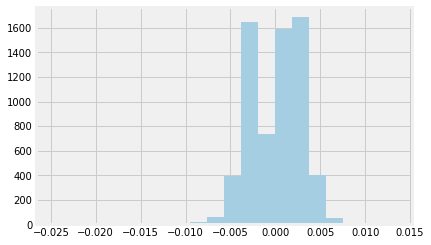

In [181]:
plt.hist(rule_tables_all['coef'], bins = 20)

In [183]:
len(rule_tables_all[rule_tables_all['coef'] > 0.003])

1044

In [184]:
len(rule_tables_all)

6638

In [185]:
rule_tables_all.to_csv('rule_tables_all.csv')

In [186]:
rule_tables_all.head()

,rule,type,coef,Total Number,support,importance,seed
46,dbp >= 0.5996060817008565 & sbp >= 1.223976331...,rule,-0.003271,95,0.054566,0.000743,0
47,dbp >= -1.1873062569523298 & sbp < 1.223976331...,rule,0.001574,1411,0.810454,0.000617,0
48,dbp < -1.1873062569523298 & sbp < 1.2239763313...,rule,-0.002689,144,0.082711,0.000741,0
49,pc < -0.4811434344187665 & dbp >= -1.187306256...,rule,0.001609,464,0.266513,0.000711,0
50,dbp < -1.1873062569523298 & potassium >= 0.132...,rule,-0.002662,87,0.049971,0.000580,0


In [187]:
rule002 = rule_tables_all[rule_tables_all['importance'] > 0.002]
rule005 = rule_tables_all[abs(rule_tables_all['coef']) >0.005]

In [189]:
rule002_count = rule002.groupby(by=['seed']).count()
rule005_count = rule005.groupby(by=['seed']).count()

In [190]:
rule002_count = pd.DataFrame(rule002_count)
rule002_count.head()

,rule,type,coef,Total Number,support,importance
seed,,,,,,
0,4,4,4,4,4,4
1,6,6,6,6,6,6
2,3,3,3,3,3,3
3,2,2,2,2,2,2
4,2,2,2,2,2,2


In [192]:
np.mean(rule002_count['rule']), np.std(rule002_count['rule'])

(3.6333333333333333, 1.3034143197344767)

In [43]:
with open('results/ctgan_tree_mrs2.txt', 'w') as filehandle:
    for listitem in res2['res_tree']:
        filehandle.write(f'{listitem}\n')
        
with open('results/ctgan_ensemble_mrs2.txt', 'w') as filehandle:
    for listitem in res2['res_lasso']:
        filehandle.write(f'{listitem}\n')

# Extract rule matrix

In [126]:
train_X = np.array(merge2[pre_treatment_var])
rules_all_X = final_model2.extract_rule_matrix_all(train_X)

In [127]:
rules_ex_X = final_model2.extract_rule_matrix(train_X)

In [128]:
rules_ex_df = pd.DataFrame(rules_ex_X)
rules_all_df = pd.DataFrame(rules_all_X)

In [129]:
rules_ex_df = rules_ex_df.loc[:, (rules_ex_df != 0).any(axis=0)]

In [130]:
rules_ex_df.shape, rules_all_df.shape

((1741, 187), (1741, 212))

In [131]:
corr_ex = rules_ex_df.corr()
abs_corr_ex = abs(corr_ex.values)
abs_lower_ex = np.tril(abs_corr_ex, -1)

In [132]:
corr_all = rules_all_df[pd.isnull(rules_all_df)==False].corr()
abs_corr_all = abs(corr_all.values)
abs_lower_all = np.tril(abs_corr_all, -1)

In [134]:
np.mean(abs_lower_ex), np.mean(abs_lower_all)

(0.03725910523161013, 0.0386577869236661)

In [143]:
rules = final_model2.get_rules()
rules_all_X = final_model2.extract_rule_matrix_all(train_X)

In [146]:
rules

,rule,type,coef,Total Number,support,importance
0,age,linear,0.000071,1,0.000069,NaN
1,ich_vol,linear,-0.000006,1,0.000006,NaN
2,ivh_vol,linear,0.000000,1,0.000000,NaN
3,gcs,linear,0.000576,1,0.000576,NaN
4,nihss,linear,0.000029,1,0.000021,NaN
...,...,...,...,...,...,...
253,wbc < 0.15005646249826265 & potassium < -0.760...,rule,-0.003264,128,0.073521,0.000852
254,aptt >= 0.5069187837145486 & gcs >= -2.2658628...,rule,0.002856,332,0.190695,0.001122
255,gcs < -2.2658628408161348,rule,-0.002419,85,0.048823,0.000521
256,pc < -1.360918741874409 & map >= -1.4713906496...,rule,0.001813,83,0.047674,0.000386


In [147]:
rules_r = rules[rules['type']=='rule']
rules_r.index = np.arange(0, len(rules_r))

In [149]:
rules_all_X.shape, rules_r.shape

((1741, 212), (212, 6))

In [150]:
# Extract top 5 positive rules and top 5 negative rules
top_p = rules_r[rules_r['coef'] > 0].sort_values("importance", ascending=False).head(5).index
top_n = rules_r[rules_r['coef'] < 0].sort_values("importance", ascending=False).head(5).index

In [153]:
top_rules = list(top_p) + list(top_n)

In [154]:
rules_top_X = rules_all_X[:, top_rules]

In [156]:
rules_top_X.shape

(1741, 10)

In [158]:
rules_top_df = pd.DataFrame(rules_top_X)
corr_top = rules_top_df.corr()
abs_corr_top = abs(corr_top.values)
abs_lower_top = np.tril(abs_corr_top, -1)
np.mean(abs_lower_top)

0.12935437375449305

# Rule reformatting

In [52]:
rules_sorted = rules_[rules_.coef != 0].sort_values("importance", ascending=False)

In [161]:
rules_sorted['importance'].describe()

count    1.870000e+02
mean     8.666883e-04
std      4.451179e-04
min      5.595580e-07
25%      6.357725e-04
50%      8.230473e-04
75%      1.011979e-03
max      3.450880e-03
Name: importance, dtype: float64

In [53]:
positive_rules = rules[rules['coef'] > 0]
positive_sorted = positive_rules.sort_values("importance", ascending=False)
positive_sorted.index = np.arange(0, len(positive_sorted))
negative_rules = rules[rules['coef'] < 0]
negative_sorted = negative_rules.sort_values('importance', ascending=False)
negative_sorted.index = np.arange(0, len(negative_sorted))

In [159]:
positive_sorted['coef'].describe()

count    105.000000
mean       0.002634
std        0.002154
min        0.000002
25%        0.001617
50%        0.002473
75%        0.003257
max        0.016661
Name: coef, dtype: float64

In [ ]:
positive_sorted['coef'].describe()

In [160]:
positive_sorted['importance'].describe()

count    9.300000e+01
mean     9.220213e-04
std      5.281909e-04
min      5.595580e-07
25%      6.381770e-04
50%      8.232225e-04
75%      1.121565e-03
max      3.450880e-03
Name: importance, dtype: float64

In [54]:
a = positive_sorted.iloc[:10, :]

In [55]:
b = negative_sorted.iloc[:10, :]

In [56]:
a

,rule,type,coef,Total Number,support,importance
0,dbp >= -1.147597093871148 & sbp < 1.3762474392...,rule,0.008964,1426,0.819070,0.003451
1,ICHLOC_Other < 0.1 & dbp >= -1.147597093871148,rule,0.008370,1479,0.849512,0.002993
2,nihss >= 1.3862943611198906 & dbp >= -1.147597...,rule,0.005721,1444,0.829408,0.002152
3,hemoglobin < -0.7905265706476053 & dbp >= -1.1...,rule,0.005438,296,0.170017,0.002043
4,dbp >= -1.147597093871148 & dbp < 1.9100084633...,rule,0.005150,1489,0.855256,0.001812
5,pc < -0.4799119460264714 & creatinie >= -0.459...,rule,0.004089,417,0.239518,0.001745
6,ICHLOC_Basal Ganglia >= 0.1 & pp < 0.733425710...,rule,0.003813,517,0.296956,0.001742
7,cd >= 0.030247060583091158 & nihss >= 3.044522...,rule,0.006866,111,0.063756,0.001678
8,pc < -0.5057732022646692 & glucose < 0.4256016...,rule,0.003518,412,0.236646,0.001495
9,cd >= 0.6721176443331565 & potassium < 0.26046...,rule,0.003943,270,0.155083,0.001427


In [78]:
a.loc[4, 'rule']

'dbp >= -1.147597093871148 & dbp < 1.91000846337986'

In [66]:
1.3762 * np.std(merge2['BP_S0']) + np.mean(merge2['BP_S0'])

214.9984422754759

In [79]:
1.91 * np.std(merge2['BP_D0']) + np.mean(merge2['BP_D0'])

146.9997868658213

In [68]:
-0.7905*np.std(merge2['LB_HEMOGLOBIN']) + np.mean(merge2['LB_HEMOGLOBIN'])

12.500053859980708

In [110]:
np.exp(1.3863) - 1

3.0000225555840316

In [109]:
-1.0846 * np.std(merge2['BP_D0']) + np.mean(merge2['BP_D0'])

71.00070606229858

In [57]:
b

,rule,type,coef,Total Number,support,importance
0,hemoglobin >= -0.7905265706476053 & ICHLOC_Bas...,rule,-0.004636,869,0.499138,0.002318
1,dbp < -1.147597093871148,rule,-0.006303,159,0.091327,0.001816
2,dbp < -1.3858520723582395,rule,-0.007700,83,0.047674,0.001641
3,map < -0.8621785659626651 & cd >= -0.451155877...,rule,-0.004085,244,0.140149,0.001418
4,pc >= -0.5057732022646692 & hematocrit >= -1.1...,rule,-0.002774,1106,0.635267,0.001335
5,age < -0.5297135786169122 & creatinie < 0.0005...,rule,-0.002938,395,0.226881,0.001231
6,pc >= -0.5291714817182768 & bun >= -0.81312864...,rule,-0.002498,1100,0.631821,0.001205
7,aptt < -0.3855362306770197 & nihss >= 1.791759...,rule,-0.002805,423,0.242964,0.001203
8,pp >= 0.6792798754487963 & HIS_DM2 < 0.1,rule,-0.003286,261,0.149914,0.001173
9,sbp >= -0.5728227422799363 & map >= 1.43759705...,rule,-0.004417,130,0.074670,0.001161


In [106]:
b.loc[4, 'rule']

'pc >= -0.5057732022646692 & hematocrit >= -1.1085110269146483'

In [108]:
-1.1085*np.std(merge2['LB_POTASSIUM']) + np.mean(merge2['LB_POTASSIUM'])

3.227087119817433

In [105]:
-0.5058* np.std(merge2['LB_PC']) + np.mean(merge2['LB_PC'])

190.99782395550795

# Subgroup HTE

In [37]:
trial_all = df[df['source']=='atach2'].copy()
trial_all = pd.get_dummies(trial_all)
trial_all = test_transform_var(trial_all, merge2)

In [38]:
trial_X = np.array(trial_all[pre_treatment_var])

In [39]:
pred_trial = final_model2.predict(trial_X)

In [40]:
trial_all['hte'] = pred_trial

In [62]:
trial_all['hte'].describe()

count    1000.000000
mean        0.005183
std         0.035147
min        -0.138227
25%        -0.010171
50%         0.006846
75%         0.028042
max         0.090081
Name: hte, dtype: float64

In [123]:
a = trial_all[trial_all['BP_D0']<70].copy()
a.head()

,TREATMENT,DEMO_AGE,OUTCOME_mRS90,CT1_ICHVOL,CT1_IVHVOL,GCS_TTL,NIHSS_TTL,BP_S0,BP_D0,HIS_HYPERTENSION,...,chloride,cd,bun,hemoglobin,hematocrit,wbc,creatinie,aptt,inr,hte
8,1,55.0,1.0,8.30103,1.43508,15.0,9.0,147.0,65.0,1.0,...,0.009436,1.367477,-0.874932,0.146797,0.038271,-0.052848,-0.552872,-0.725982,-0.441902,-0.080512
15,0,56.0,4.0,22.03439,0.00000,10.0,27.0,165.0,66.0,0.0,...,-0.249268,1.100031,-0.607117,-0.297198,-0.758645,0.686732,-0.212329,-1.029952,0.047850,-0.042896
27,0,85.0,2.0,2.91347,0.00000,15.0,3.0,156.0,59.0,1.0,...,3.631294,-1.039537,0.113923,-1.283855,-1.613873,0.211288,-0.425168,-1.941861,0.047850,-0.071721
39,0,66.0,3.0,3.20415,0.00000,15.0,3.0,150.0,61.0,1.0,...,1.044252,-0.237199,0.319935,-0.543862,-0.855830,0.499436,-0.354222,-0.166678,0.047850,-0.089475
53,0,62.0,2.0,1.50411,0.00000,15.0,5.0,142.0,69.0,1.0,...,0.785548,0.297693,0.216929,0.492127,0.446448,-0.533095,0.000509,-0.057249,-0.441902,-0.013452


In [124]:
sum(a['TREATMENT'])

48

In [81]:
trial_test = trial_all[trial_all['group_test'] == 1]
trial_test['hte'].describe()

count    200.000000
mean       0.004313
std        0.034967
min       -0.122532
25%       -0.009818
50%        0.005927
75%        0.025785
max        0.086781
Name: hte, dtype: float64

In [82]:
len(trial_test[trial_test['hte']>0])

119

In [87]:
temp =trial_test[(trial_test['BP_D0']>=70 ) & (trial_test['BP_S0'] < 215)] 
temp['hte'].describe()

count    168.000000
mean       0.013835
std        0.023784
min       -0.038860
25%       -0.003901
50%        0.010749
75%        0.029603
max        0.086781
Name: hte, dtype: float64

In [89]:
temp1 = trial_test[(trial_test['ICHLOC_Other']==0)&(trial_test['BP_D0']>=70)] 
temp1['hte'].describe()

count    175.000000
mean       0.013712
std        0.023424
min       -0.038860
25%       -0.003914
50%        0.010257
75%        0.029365
max        0.086781
Name: hte, dtype: float64

In [90]:
temp2 = trial_test[(trial_test['NIHSS_TTL']>=3.0) & (trial_test['BP_D0'] >= 70)]
temp2['hte'].describe()

count    169.000000
mean       0.014480
std        0.023142
min       -0.038860
25%       -0.003526
50%        0.011876
75%        0.029984
max        0.086781
Name: hte, dtype: float64

In [91]:
temp3 = trial_test[(trial_test['LB_HEMOGLOBIN']< 12.5)&(trial_test['BP_D0']>=70)]
temp3['hte'].describe()

count    20.000000
mean      0.029750
std       0.025466
min      -0.025913
25%       0.016167
50%       0.027375
75%       0.040256
max       0.086781
Name: hte, dtype: float64

In [92]:
temp4 = trial_all[(trial_all['BP_D0']>=70.0)&(trial_all['BP_D0']<147.0)]
temp4['hte'].describe()

count    887.000000
mean       0.013387
std        0.025547
min       -0.063056
25%       -0.004596
50%        0.010468
75%        0.030705
max        0.090081
Name: hte, dtype: float64

In [98]:
temp5 = trial_test[(trial_test['LB_HEMOGLOBIN']>=12.5)&(trial_test['ICHLOC_Basal Ganglia']==0)]
temp5['hte'].describe()

count    82.000000
mean     -0.003907
std       0.036495
min      -0.122532
25%      -0.013514
50%      -0.001194
75%       0.018135
max       0.062289
Name: hte, dtype: float64

In [100]:
temp6 = trial_test[trial_test['BP_D0']<70]
temp6['hte'].describe()

count    23.000000
mean     -0.064351
std       0.031474
min      -0.122532
25%      -0.078790
50%      -0.062239
75%      -0.045648
max      -0.000884
Name: hte, dtype: float64

In [101]:
temp7 = trial_test[(trial_test['BP_D0']<64)]
temp7['hte'].describe()

count    11.000000
mean     -0.082170
std       0.030346
min      -0.122532
25%      -0.108223
50%      -0.084703
75%      -0.054560
max      -0.035511
Name: hte, dtype: float64

In [102]:
temp8 = trial_test[(trial_test['MAP']<104) & (trial_test['LB_CD'] >= 23.2)]
temp8['hte'].describe()

count    31.000000
mean     -0.026130
std       0.048017
min      -0.110404
25%      -0.067196
50%      -0.006633
75%       0.005069
max       0.086781
Name: hte, dtype: float64

In [109]:
temp9 = trial_test[(trial_test['LB_PC'] >= 191.0)&(trial_test['LB_POTASSIUM']>=3.2)]
temp9['hte'].describe()

count    125.000000
mean      -0.005531
std        0.030819
min       -0.122532
25%       -0.010848
50%        0.000079
75%        0.013266
max        0.047196
Name: hte, dtype: float64

In [167]:
temp9 = trial[(trial['glucose']>=-0.5627)&(trial['pp']<0.2967)]
temp9['hte'].describe()

count    463.000000
mean       0.031479
std        0.033821
min       -0.086181
25%        0.013452
50%        0.038207
75%        0.056649
max        0.111668
Name: hte, dtype: float64

# Plot

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from localreg import *

In [42]:
x = np.array(trial_all['BP_D0'])
y = np.array(trial_all['hte'])
order = np.argsort(x)
xs = x[order]
ys = y[order]
y_hat = localreg(xs, ys, degree = 10, kernel=rbf.biweight, radius = 3)
polymodel = np.poly1d(np.polyfit(xs, ys, 3))

In [43]:
y_hat2 = polymodel(xs)

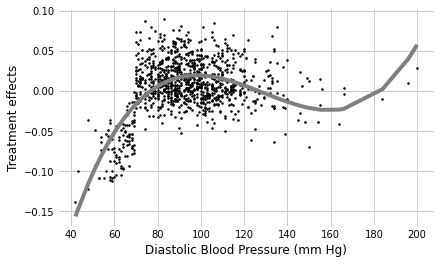

In [44]:
fig, ax = plt.subplots()
# Plot the data
ax.plot(xs, ys, '.', markersize=3.0, color='black')
ax.plot(xs, y_hat2, label='Local quadratic regression', color='gray')
ax.set_xlabel("Diastolic Blood Pressure (mm Hg)")
ax.set_ylabel("Treatment effects")

# Set the background color of the plot area (inside the axes) to white
ax.set_facecolor('white')

# Remove the spines (the borders) of the plot
for spine in ax.spines.values():
    spine.set_visible(False)

# Display the plot
plt.show()

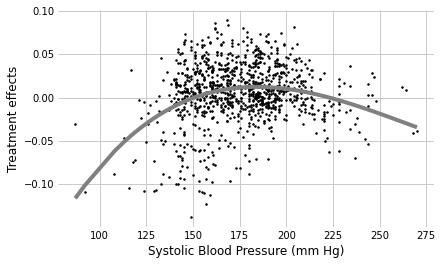

In [52]:
x = np.array(trial_all['BP_S0'])
y = np.array(trial_all['hte'])
order = np.argsort(x)
xs = x[order]
ys = y[order]
polymodel = np.poly1d(np.polyfit(xs, ys, 3))
y_hat = polymodel(xs)
fig, ax = plt.subplots()
# Plot the data
ax.plot(xs, ys, '.', markersize=3.0, color='black')
ax.plot(xs, y_hat, label='Local quadratic regression', color='gray')
ax.set_xlabel("Systolic Blood Pressure (mm Hg)")
ax.set_ylabel("Treatment effects")

# Set the background color of the plot area (inside the axes) to white
ax.set_facecolor('white')

# Remove the spines (the borders) of the plot
for spine in ax.spines.values():
    spine.set_visible(False)

# Display the plot
plt.show()

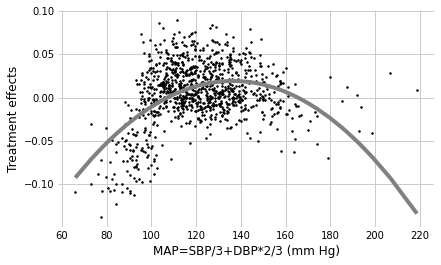

In [55]:
x = np.array(trial_all['MAP'])
y = np.array(trial_all['hte'])
order = np.argsort(x)
xs = x[order]
ys = y[order]
polymodel = np.poly1d(np.polyfit(xs, ys, 2))
y_hat = polymodel(xs)
fig, ax = plt.subplots()
# Plot the data
ax.plot(xs, ys, '.', markersize=3.0, color='black')
ax.plot(xs, y_hat, label='Local quadratic regression', color='gray')
ax.set_xlabel("MAP=SBP/3+DBP*2/3 (mm Hg)")
ax.set_ylabel("Treatment effects")

# Set the background color of the plot area (inside the axes) to white
ax.set_facecolor('white')

# Remove the spines (the borders) of the plot
for spine in ax.spines.values():
    spine.set_visible(False)

# Display the plot
plt.show()

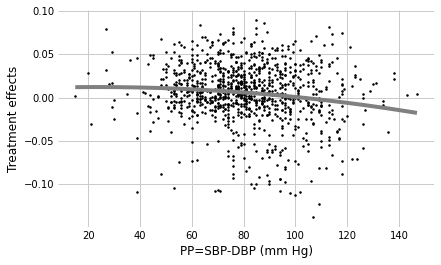

In [56]:
x = np.array(trial_all['PP'])
y = np.array(trial_all['hte'])
order = np.argsort(x)
xs = x[order]
ys = y[order]
polymodel = np.poly1d(np.polyfit(xs, ys, 2))
y_hat = polymodel(xs)
fig, ax = plt.subplots()
# Plot the data
ax.plot(xs, ys, '.', markersize=3.0, color='black')
ax.plot(xs, y_hat, label='Local quadratic regression', color='gray')
ax.set_xlabel("PP=SBP-DBP (mm Hg)")
ax.set_ylabel("Treatment effects")

# Set the background color of the plot area (inside the axes) to white
ax.set_facecolor('white')

# Remove the spines (the borders) of the plot
for spine in ax.spines.values():
    spine.set_visible(False)

# Display the plot
plt.show()